# Quantum Machine Learning and Quantum Support Vector Classifier (QSVC)

## Required Libraries

1. Pennylane - for quantum circuit simulations
2. scikit-learn - for Machine Learning

`Uncomment the code cell below to instal the two libraries`

In [1]:
# !pip install pennylane==0.37
# !pip install scikit-learn==1.5.1

## Introduction to Machine Learning

Machine learning is a subset of artificial intelligence (AI) focused on building systems that learn from data and improve their performance over time without being explicitly programmed. It involves algorithms that can recognize patterns, make decisions, and predict outcomes based on input data.

### Key Concepts

1. **Data**: The foundation of machine learning. Data is often split into training sets (to teach the model) and testing sets (to evaluate the model's performance).
   
2. **Algorithms**: Procedures or methods for solving a problem. Common machine learning algorithms include Support Vector Machines, linear regression, decision trees, and neural networks.
   
3. **Models**: The output of the learning process. Models represent patterns learned from the training data and are used to make predictions or decisions.

4. **Training**: The process of feeding data into the algorithm to help it learn. During training, the model adjusts its parameters to minimize errors.

5. **Evaluation**: Assessing the model's performance using metrics like accuracy, precision, recall, and F1-score.

### Types of Machine Learning

1. **Supervised Learning**: The model is trained on labeled data, meaning the input comes with corresponding output. Examples include classification and regression tasks.
   
2. **Unsupervised Learning**: The model is trained on unlabeled data and must find patterns and relationships in the data. Examples include clustering and association tasks.


## Classification and Support Vector Machines (SVMs)

### Classification

Classification is a type of supervised learning in machine learning where the goal is to categorize input data into predefined classes or labels. Given a dataset with known labels, a classification algorithm learns to assign labels to new, unseen data based on the patterns it has learned during training.

#### Common Applications
- **Spam Detection**: Classifying emails as spam or non-spam.
- **Image Recognition**: Identifying objects within images, such as distinguishing between cats and dogs.
- **Medical Diagnosis**: Classifying medical images or patient data into disease categories.

### Support Vector Machines (SVMs)

Support Vector Machines (SVMs) are powerful and versatile supervised learning models used for classification and regression tasks. They are particularly effective in high-dimensional spaces and are known for their robustness in handling both linear and non-linear data.

The support vector machine algorithm tries to find the parameters $w$ and $b$ such that the data with labels $y=1$ satisfy $w\,x+b>1$, and the data $y=-1$ satisfy $w\,x+b<1$. The optimization problem therefore consists in maximizing the distance between the two hyperplanes $\frac{2}{\vert \vert w \vert \vert}$ (or minimizing $\vert \vert w \vert \vert^2$) given the constraints $y_i (w\,x+b)>1$. This problem corresponds to the optimization of a quadratic problem with linear constraints 

$\min \limits_{w,b}\vert \vert w\vert \vert^2 \text{ such that }$ <p>

$y_i (w \, x_i+b)\geq 1, i=1...N$

<img src="linear_svm_hardcore.png" alt="isolated" width="800"/>

### Dual Formulation of SVM

One can show (using Lagrange multipliers) that the optimization problem of the SVM is equivalent to its dual formulation. The dual problem takes the form:

$\max \limits_{\{\alpha_i\}}\sum_i-\frac{1}{2}\sum_{j,k}\alpha_j\alpha_k y_j y_k (x_j^Tx_k)$  with the constraints <p>$ 0 \leq \alpha_i \leq C \text{ and } \sum_i \alpha_i y_i=0$

One of the advantages of this formulation is that it only involves the scalar products $ x_j^T x_k$. This is a crucial point for quantum SVM. 

### Kernel Functions

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and 
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

#### Key Concepts

1. **Hyperplane**: In SVMs, the algorithm tries to find the optimal hyperplane that best separates the data into different classes. For a two-dimensional space, this hyperplane is a line; for higher dimensions, it is a flat affine subspace.

2. **Support Vectors**: The data points that are closest to the hyperplane. These points are crucial in defining the position and orientation of the hyperplane.

3. **Margin**: The distance between the hyperplane and the nearest support vectors from any class. SVM aims to maximize this margin to ensure the best separation between classes.

4. **Feature maps**: Feature maps can help us transform the feature space into a complex higher dimensional space where inseparable data become linearly separable.

5. **Kernel Trick**: SVMs can efficiently perform a non-linear classification using the kernel trick, implicitly mapping input features into high-dimensional feature spaces. Common kernels include linear, polynomial, and radial basis function (RBF) kernels. (See `Mercer's Theorem` for why this is works)

In [2]:
def demo_linear(kernel_type:str='linear', samples:int=1000, std:int=1):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.datasets import make_blobs
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    from sklearn.svm import SVC
    # Generate a synthetic dataset using make_blobs
    X, y = make_blobs(n_samples=samples,     # number of samples
                    n_features=2,       # number of features
                    centers=2,          # number of centers (clusters)
                    cluster_std=std,    # standard deviation of the clusters
                    random_state=42)    # random seed for reproducibility

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train a Random Forest Classifier
    clf = SVC(kernel=kernel_type)
    clf.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = clf.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Plot the synthetic dataset and the decision boundary
    plt.figure(figsize=(15, 6),dpi=100)

    # Plot the synthetic dataset
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title("Synthetic Dataset")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot the decision boundary
    plt.subplot(1, 2, 2)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=50, cmap='viridis')
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    plt.tight_layout()
    plt.show()


Accuracy: 1.00
Confusion Matrix:
[[151   0]
 [  0 149]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00       149

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



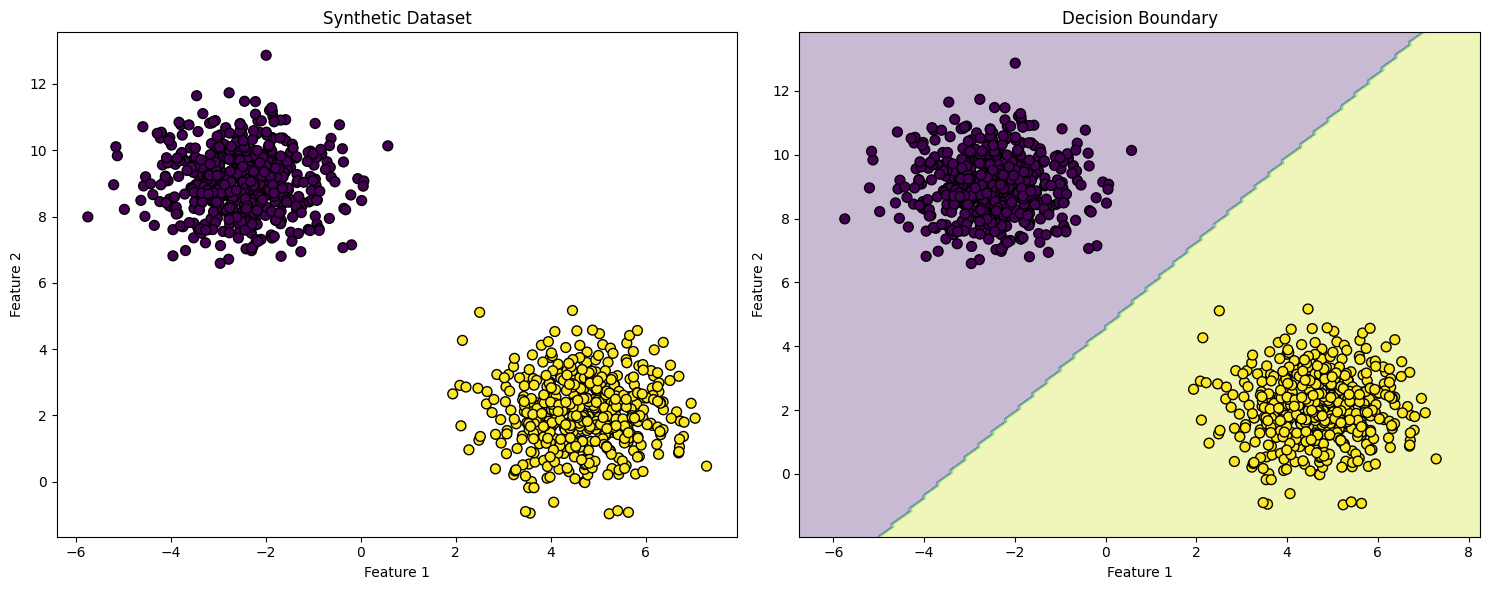

In [3]:
demo_linear()

In [4]:
def demo_circle(kernel_type:str='linear',n_samples:int=1000, noise:float=0.1):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.datasets import make_circles
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

    # Generate a synthetic dataset using make_circles
    X, y = make_circles(n_samples=n_samples,     # number of samples
                        noise=noise,          # standard deviation of Gaussian noise added to the data
                        factor=0.4,         # scale factor between the large and small circle
                        random_state=42)    # random seed for reproducibility

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train a Random Forest Classifier
    # clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf = SVC(kernel=kernel_type)
    clf.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = clf.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Plot the synthetic dataset and the decision boundary
    plt.figure(figsize=(15, 6),dpi=100)

    # Plot the synthetic dataset
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title("Synthetic Dataset")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Plot the decision boundary
    plt.subplot(1, 2, 2)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=50, cmap='viridis')
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

Accuracy: 0.60
Confusion Matrix:
[[ 56 100]
 [ 20 124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.36      0.48       156
           1       0.55      0.86      0.67       144

    accuracy                           0.60       300
   macro avg       0.65      0.61      0.58       300
weighted avg       0.65      0.60      0.57       300



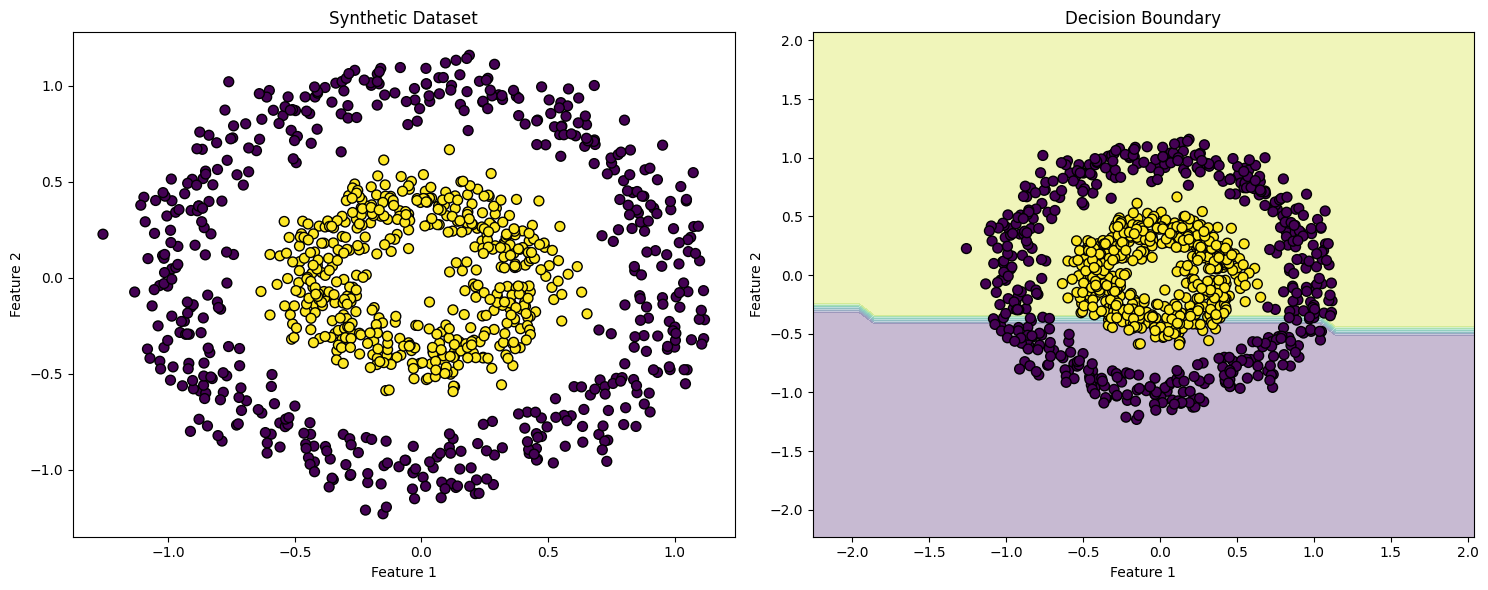

In [5]:
demo_circle()

Using `rbf` - Radial basis function kernel

Accuracy: 1.00
Confusion Matrix:
[[156   0]
 [  0 144]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       144

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



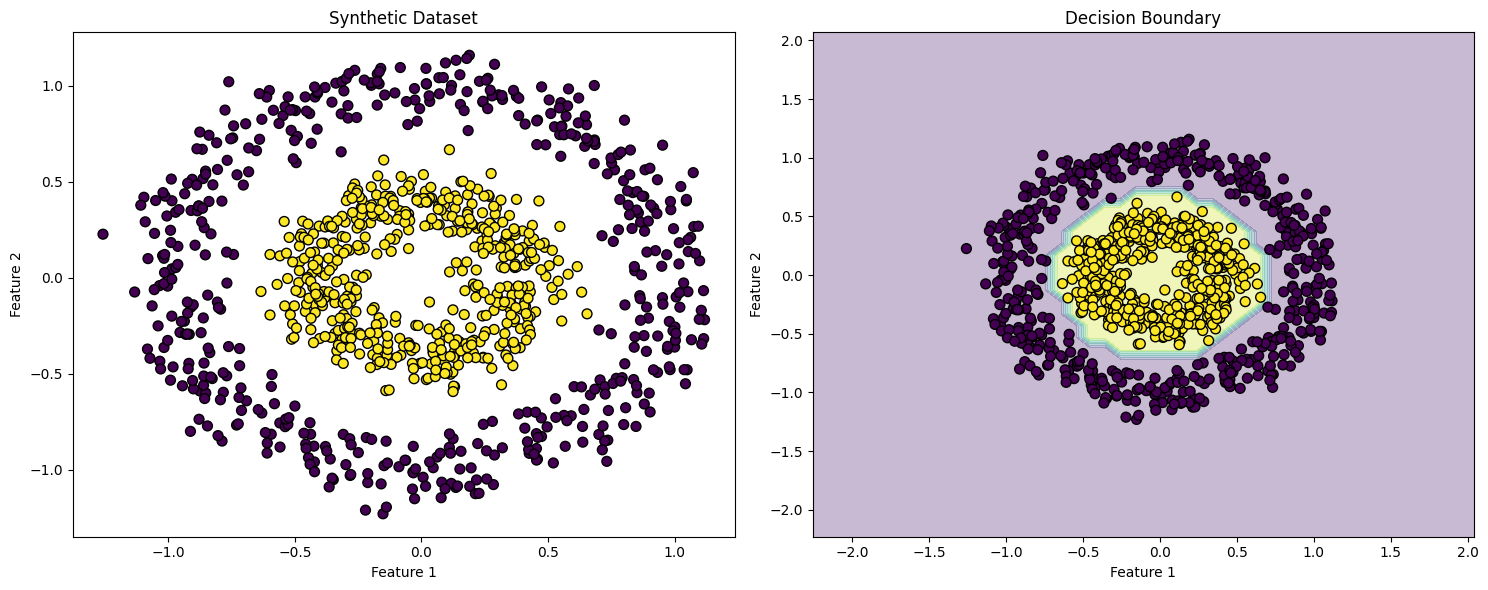

In [6]:
demo_circle(kernel_type='rbf') 


#### Advantages of SVMs
- Effective in high-dimensional spaces.
- Works well with a clear margin of separation.
- Robust against overfitting, especially in high-dimensional space.

#### Applications of SVMs
- **Fraud Detection**: Detecting fraudulent credit-card transaction.
- **Image Classification**: Identifying objects within images.

## Quantum Support Vector Classification (QSVC)

QSVC is a variant of the traditional Support Vector Machine (SVM) that leverages quantum computing principles to enhance performance. It is part of the emerging field of Quantum Machine Learning, which seeks to utilize quantum algorithms to solve complex machine learning problems more efficiently than classical approaches.

### Quantum Kernels

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms, as you will see in the examples below.

In [7]:
# Importing Required Libraries
import time

import numpy as np
import matplotlib.pyplot as plt

# scikit-learn
import sklearn
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import pennylane as qml
from pennylane.templates import AngleEmbedding

np.random.seed(42)

print(f'Pennylane version: {qml.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')

Pennylane version: 0.37.0
scikit-learn version: 1.5.1


Loading the [Iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [8]:
X, y = load_iris(return_X_y=True)
print(f'Shape of data: {X.shape, y.shape}')

Shape of data: ((150, 4), (150,))


In [9]:
# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# # scaling the labels to -1, 1 is important for the SVM and the
# # definition of a hinge loss
y_scaled = 2 * (y - 0.5)


In [10]:
# Splitting the data in to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2,random_state=42)

# scaling the inputs is important since the embedding we use is periodic
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Training set shape: (80, 4)
Testing set shape: (20, 4)


Defining our quantum ciruit (quantum feature map).

In [11]:
# Initialize the quantum device
n_qubits = X.shape[1] # number of features == number of qubits

dev= qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev, interface="autograd")
def inner_product(x1, x2):
    """The quantum kernel."""

    for qubit in range(n_qubits):
        qml.RX(phi=x1[qubit],wires=qubit)
        qml.RX(phi=-1*x2[qubit],wires=qubit)

    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

RX Gate - single qubit rotation about the Pauli X ($\sigma_{x}$).

\begin{split}R_x(\phi) = e^{-i\phi\sigma_x/2} = \begin{bmatrix}
    \cos(\phi/2) & -i\sin(\phi/2) \\
    -i\sin(\phi/2) & \cos(\phi/2)
\end{bmatrix}.\end{split}

This is the kernel entry we want to calculate

$K(\vec{x_i}, \vec{x_j}) = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2} = |\langle 0^n \vert \mathcal{U}(\vec{x_i})^{\dag} \mathcal{U}(\vec{x_j}) \vert 0^n \rangle|^2$

For the above example $\mathcal{U}$ is the n qubit $\mathcal{RX}^n$ gate. Therefore 

$K(\vec{x_i}, \vec{x_j}) = |\langle 0^n \vert \mathcal{RX}(\vec{x_i})^{\dag} \mathcal{RX}(\vec{x_j}) \vert 0^n \rangle|^2$


Drawing the quantum circuit

(<Figure size 500x500 with 1 Axes>, <Axes: >)

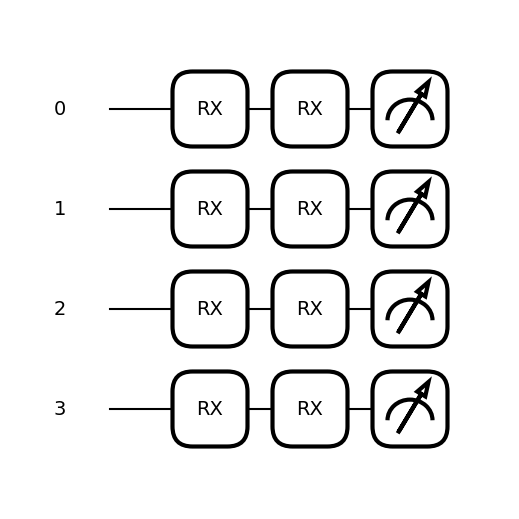

In [12]:
qml.draw_mpl(inner_product,style='black_white')(X_train[0], X_train[1])

Another way to calculate the inner product is given below but without using the projector. 

In [13]:
# @qml.qnode(dev, interface="autograd")
# def inner_product(x1, x2):
#     """The quantum kernel."""

#     for qubit in range(n_qubits):
#         qml.RX(phi=x1[qubit],wires=qubit)
#         qml.RX(phi=-1*x2[qubit],wires=qubit)

#     return qml.state()

# inner_product(X[1],X[2])[0]**2

Now we can calculate the whole kernel matrix by combining all of the kernel entries.

In [14]:
def quantum_kernel(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    n = A.shape[0]
    m = B.shape[0]
    
    if n == m:
        gram_matrix = np.diag(np.full(n,1))
        for row in range(n):
            for col in range(m):
                if row < col:
                    gram_matrix[row, col] = inner_product(A[row], B[col])
        
        gram_matrix = gram_matrix + gram_matrix.T
        
        return gram_matrix
    else:
        return np.array([[inner_product(a, b) for b in B] for a in A])

# def quantum_kernel(A, B):
#     """Compute the matrix whose entries are the kernel
#        evaluated on pairwise data from sets A and B."""
#     return np.array([[inner_product(a, b) for b in B] for a in A])

Running QSVC using a quantum kernel

In [15]:
start = time.time()

# Defining SVC 
qsvc = SVC(kernel=quantum_kernel)

# Fitting the clssifier
qsvc.fit(X_train, y_train)

# Making predictions on the Test set
predictions = qsvc.predict(X_test)

# Calculating the results
print(f'Classification report:\n {classification_report(y_test, predictions,digits=3)}')

print(f'Time taken to train and test: {time.time() - start}')

Classification report:
               precision    recall  f1-score   support

        -1.0      1.000     1.000     1.000        12
         1.0      1.000     1.000     1.000         8

    accuracy                          1.000        20
   macro avg      1.000     1.000     1.000        20
weighted avg      1.000     1.000     1.000        20

Time taken to train and test: 5.956099271774292


In [16]:
@qml.qnode(dev)
def pny_state(x):
    angle = np.pi/4
    for para in range(n_qubits):
        qml.RX(phi=angle*x[para],wires=para)
    return qml.state()

def pny_feature_state(rows):
    psi = np.array([])
    for i in range(rows.shape[1]):
        sv = pny_state(rows[:,i])
        psi = np.append(psi, sv)
    psi = np.reshape(psi, (rows.shape[1], 2**n_qubits))
    return psi

Running QSVC using a quantum kernel but here we simulate the state vector and then compute the kernel matrix instead of directly computing the kernel entries.

Time Taken: 0.12366676330566406
              precision    recall  f1-score   support

        -1.0      1.000     1.000     1.000        12
         1.0      1.000     1.000     1.000         8

    accuracy                          1.000        20
   macro avg      1.000     1.000     1.000        20
weighted avg      1.000     1.000     1.000        20



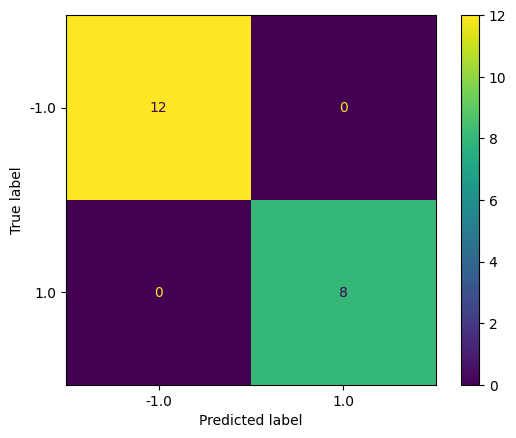

In [17]:
qsvc = SVC(kernel='precomputed')

start = time.time()

psi_train = pny_feature_state(X_train.T)
psi_test = pny_feature_state(X_test.T)

gram_train = psi_train.real @ psi_train.real.T + psi_train.imag @ psi_train.imag.T
gram_test = psi_test.real @ psi_train.real.T + psi_test.imag @ psi_train.imag.T

qsvc.fit(gram_train,y_train)

Ypred = qsvc.predict(gram_test)

ConfusionMatrixDisplay.from_predictions(y_test, Ypred)  

test_metrics = classification_report(y_test, Ypred, zero_division=0,digits=3)

print(f'Time Taken: {time.time() - start}')
print(test_metrics)

Some details about the Kernel Matrix and quantum circuit simulations

In [18]:
def n_cir(test_size:float ,data_points:int):

    n_train = round(data_points * (1 - test_size))
    n_test = data_points - n_train

    train_circuits = round(n_train * (n_train - 1) * 0.5)
    test_circuits = n_test * n_train

    # print(f'Train Circuits: {train_circuits:,}')
    # print(f'Test Circuits: {test_circuits:,}')

    return train_circuits+test_circuits

print(f'Circuits that need to be simulated to calcute the Kernel Matrix for training and testing: {n_cir(0.3,1000):,}')

Circuits that need to be simulated to calcute the Kernel Matrix for training and testing: 454,650


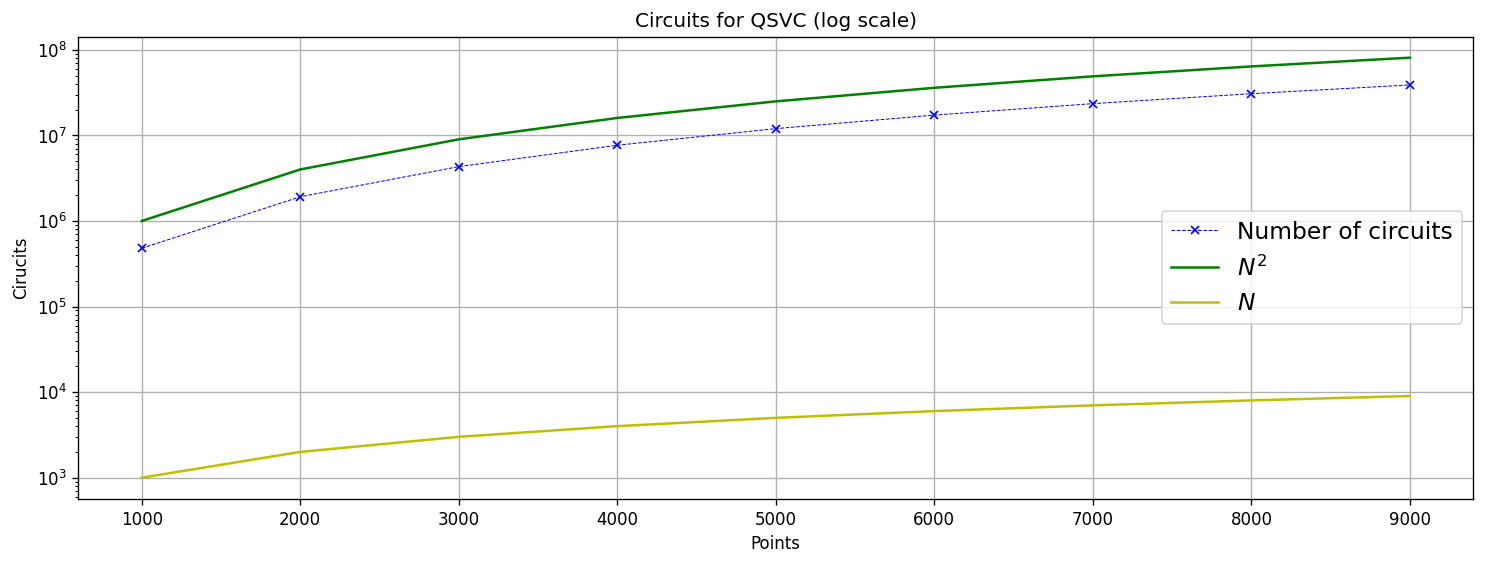

In [23]:
points = np.array([10*i for i in range(100,100*10,100)])
circs = np.array([n_cir(0.2,point) for point in points])

plt.figure(figsize=(15,5),dpi=120)

plt.plot(points,circs,ls='--',lw=0.6,marker='x',ms=5,label='Number of circuits',c='b')
plt.plot(points,points**2,label='$N^2$',c='g')
plt.plot(points,points,label='$N$',c='y')

plt.yscale('log')

plt.xlabel("Points")
plt.ylabel("Cirucits")

plt.legend(loc='right',fontsize=14)
plt.title('Circuits for QSVC (log scale)')

plt.grid()

plt.show()

## References

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209–212 (2019).

### Websites and other helpful tutorials

1. [Qiskit QSVC example](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/03_quantum_kernel.html#2.3.-Classification-with-SVC)
2. [Pennylane QSVC example](https://pennylane.ai/qml/demos/tutorial_kernels_module/)